In [ ]:
import pandas as pd
import numpy as np

In [ ]:
bike_train = pd.read_csv('train.csv')
bike_train = bike_train.set_index('date_time')
bike_test = pd.read_csv('test.csv')
bike_test = bike_test.set_index('date_time')
bike = pd.concat([bike_train,bike_test])
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
bike['temp_diff_info'] = bike['high_temp'] - bike['low_temp']
# 2. "덥고 습한 날씨"를 알기 위한 정보
bike['sweat_info'] = bike['high_temp'] * bike['humidity'] 
# 3. "춥고 바람부는 날씨"를 알기 위한 정보
bike['cold_info'] = bike['low_temp'] * bike['wind_speed'] 
bike.drop(['wind_direction', 'humidity', 'cold_info'], axis=1, inplace=True)
bike = bike[['sky_condition', 'precipitation_form', 'wind_speed', 'low_temp', 'high_temp', 'Precipitation_Probability', 'temp_diff_info', 'sweat_info', 'number_of_rentals']]

In [ ]:
train_bike_y = bike['number_of_rentals'][0:273]
train_bike_y = train_bike_y.reset_index()
train_bike_y

,date_time,number_of_rentals
0,2018-04-01,22994
1,2018-04-02,28139
2,2018-04-03,26817
3,2018-04-04,26034
4,2018-04-05,2833
...,...,...
268,2020-06-26,96150
269,2020-06-27,107001
270,2020-06-28,98568
271,2020-06-29,70053


In [ ]:
test_bike_y = bike['number_of_rentals'][273:]
test_bike_y = test_bike_y.reset_index()
test_bike_y

,date_time,number_of_rentals
0,2021-04-01,116640
1,2021-04-02,110607
2,2021-04-03,14026
3,2021-04-04,94160
4,2021-04-05,110533
...,...,...
86,2021-06-26,105813
87,2021-06-27,92869
88,2021-06-28,106378
89,2021-06-29,111907


In [ ]:
def ts_train_test_normalize(all_data, time_steps, for_periods):

    # create training and test set 
    ts_train = all_data[0:273].iloc[:,[-1]].values
    ts_test = all_data[273:].iloc[:,[-1]].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_data["number_of_rentals"][:273], all_data["number_of_rentals"][273:]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [ ]:
X_train, y_train, X_test, sc = ts_train_test_normalize(bike, 7, 2)
X_train.shape[0], X_train.shape[1]

(265, 7)

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD 

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

In [ ]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['number_of_rentals', 'prediction'])
    actual_pred['number_of_rentals'] = bike["number_of_rentals"][273:][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['number_of_rentals']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(1807880300.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f1a565d9f90>)

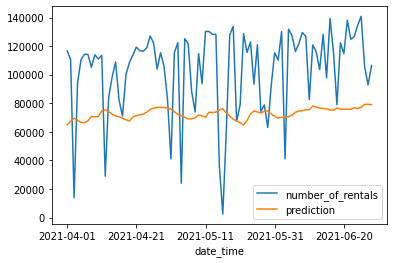

In [ ]:

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [ ]:
y_pred = LSTM_prediction[:, 0]
y_test=bike["number_of_rentals"][273:][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [ ]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [ ]:
NMAE(y_test, y_pred)

0.7426529362087873

In [ ]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(1047406400.0, <matplotlib.axes._subplots.AxesSubplot at 0x7f1a4ed9ba90>)

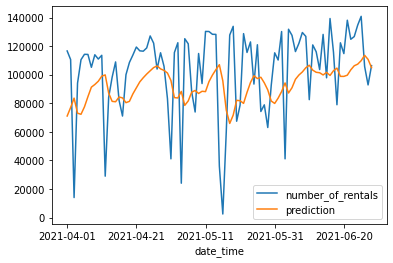

In [ ]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [ ]:
y_pred_gru = GRU_prediction[:, 0]
y_test_gru=bike["number_of_rentals"][273:][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [ ]:
NMAE(y_test_gru, y_pred_gru)

0.7733880761942377